In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Packages { display-mode: "form" }
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import glob as gl 
import scipy.optimize
from tqdm.auto import tqdm
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.spatial import distance
from scipy import signal
import seaborn as sns

from tensorflow import keras
from keras import layers, models

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.recurrent import LSTM,RNN
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 


from matplotlib import animation, patches
# ! pip install lib
# from lib import error_ellipse
!pip install pymap3d
import pymap3d as pm
import pymap3d.vincenty as pmv

# Constants
CLIGHT = 299_792_458   # speed of light (m/s)
RE_WGS84 = 6_378_137   # earth semimajor axis (WGS84) (m)
OMGE = 7.2921151467E-5  # earth angular velocity (IS-GPS) (rad/s)


In [ ]:
#@title Satellite Selection { display-mode: "form" }
# Satellite selection using carrier frequency error, elevation angle, and C/N0
def satellite_selection(df, column):
    """
    Args:
        df : DataFrame from device_gnss.csv
        column : Column name
    Returns:
        df: DataFrame with eliminated satellite signals
    """
    idx = df[column].notnull()
    idx &= df['CarrierErrorHz'] < 2.0e6         # carrier frequency error (Hz)
    idx &= df['SvElevationDegrees'] > 10.0      # elevation angle (deg)
    idx &= df['Cn0DbHz'] > 15.0                 # C/N0 (dB-Hz)
    idx &= df['MultipathIndicator'] == 0        # Multipath flag

    return df[idx]

In [ ]:
#@title Point-Positioning { display-mode: "form" }
# GNSS single point positioning using pseudorange
def point_positioning(gnss_df):
    # Add nominal frequency to each signal
    # Note: GLONASS is an FDMA signal, so each satellite has a different frequency
    CarrierFrequencyHzRef = gnss_df.groupby(['Svid', 'SignalType'])[
        'CarrierFrequencyHz'].median()
    gnss_df = gnss_df.merge(CarrierFrequencyHzRef, how='left', on=[
                            'Svid', 'SignalType'], suffixes=('', 'Ref'))
    gnss_df['CarrierErrorHz'] = np.abs(
        (gnss_df['CarrierFrequencyHz'] - gnss_df['CarrierFrequencyHzRef']))

    # Carrier smoothing
    gnss_df = carrier_smoothing(gnss_df)

    # GNSS single point positioning
    utcTimeMillis = gnss_df['utcTimeMillis'].unique()
    nepoch = len(utcTimeMillis)
    x0 = np.zeros(4)  # [x,y,z,tGPSL1]
    v0 = np.zeros(4)  # [vx,vy,vz,dtGPSL1]
    x_wls = np.full([nepoch, 3], np.nan)  # For saving position
    v_wls = np.full([nepoch, 3], np.nan)  # For saving velocity

    # Loop for epochs
    for i, (t_utc, df) in enumerate(tqdm(gnss_df.groupby('utcTimeMillis'), total=nepoch)):
        # Valid satellite selection
        df_pr = satellite_selection(df, 'pr_smooth')
        df_prr = satellite_selection(df, 'PseudorangeRateMetersPerSecond')

        # Corrected pseudorange/pseudorange rate
        pr = (df_pr['pr_smooth'] + df_pr['SvClockBiasMeters'] - df_pr['IsrbMeters'] -
              df_pr['IonosphericDelayMeters'] - df_pr['TroposphericDelayMeters']).to_numpy()
        prr = (df_prr['PseudorangeRateMetersPerSecond'] +
               df_prr['SvClockDriftMetersPerSecond']).to_numpy()

        # Satellite position/velocity
        xsat_pr = df_pr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters',
                         'SvPositionZEcefMeters']].to_numpy()
        xsat_prr = df_prr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters',
                           'SvPositionZEcefMeters']].to_numpy()
        vsat = df_prr[['SvVelocityXEcefMetersPerSecond', 'SvVelocityYEcefMetersPerSecond',
                       'SvVelocityZEcefMetersPerSecond']].to_numpy()

        # Weight matrix for peseudorange/pseudorange rate
        Wx = np.diag(1 / df_pr['RawPseudorangeUncertaintyMeters'].to_numpy())
        Wv = np.diag(1 / df_prr['PseudorangeRateUncertaintyMetersPerSecond'].to_numpy())

        # Robust WLS requires accurate initial values for convergence,
        # so perform normal WLS for the first time
        if len(df_pr) >= 4:
            # Normal WLS
            if np.all(x0 == 0):
                opt = scipy.optimize.least_squares(
                    pr_residuals, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx))
                x0 = opt.x 
            # Robust WLS for position estimation
            opt = scipy.optimize.least_squares(
                 pr_residuals, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx), loss='soft_l1')
            if opt.status < 1 or opt.status == 2:
                 print(f'i = {i} position lsq status = {opt.status}')
            else:
                 x_wls[i, :] = opt.x[:3]
                 x0 = opt.x
                 
        # Velocity estimation
        if len(df_prr) >= 4:
            if np.all(v0 == 0): # Normal WLS
                opt = scipy.optimize.least_squares(
                    prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv))
                v0 = opt.x
            # Robust WLS for velocity estimation
            opt = scipy.optimize.least_squares(
                prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv), loss='soft_l1')
            if opt.status < 1:
                print(f'i = {i} velocity lsq status = {opt.status}')
            else:
                v_wls[i, :] = opt.x[:3]
                v0 = opt.x

    return utcTimeMillis, x_wls, v_wls, 

In [ ]:
#@title Pseudorange Smoothing { display-mode: "form" }
# Carrier smoothing of pseudarange
def carrier_smoothing(gnss_df):
    """
    Args:
        df : DataFrame from device_gnss.csv
    Returns:
        df: DataFrame with carrier-smoothing pseudorange 'pr_smooth'
    """
    carr_th = 1.6 # carrier phase jump threshold [m] 2->1.5 (best)->1.0
    pr_th =  20.0 # pseudorange jump threshold [m] 20->15

    prsmooth = np.full_like(gnss_df['RawPseudorangeMeters'], np.nan)
    # Loop for each signal
    for (i, (svid_sigtype, df)) in enumerate((gnss_df.groupby(['Svid', 'SignalType']))):
        df = df.replace(
            {'AccumulatedDeltaRangeMeters': {0: np.nan}})  # 0 to NaN

        # Compare time difference between pseudorange/carrier with Doppler
        drng1 = df['AccumulatedDeltaRangeMeters'].diff() - df['PseudorangeRateMetersPerSecond']
        drng2 = df['RawPseudorangeMeters'].diff() - df['PseudorangeRateMetersPerSecond']

        # Check cycle-slip
        slip1 = (df['AccumulatedDeltaRangeState'].to_numpy() & 2**1) != 0  # reset flag
        slip2 = (df['AccumulatedDeltaRangeState'].to_numpy() & 2**2) != 0  # cycle-slip flag
        slip3 = np.fabs(drng1.to_numpy()) > carr_th # Carrier phase jump
        slip4 = np.fabs(drng2.to_numpy()) > pr_th # Pseudorange jump

        idx_slip = slip1 | slip2 | slip3 | slip4
        idx_slip[0] = True

        # groups with continuous carrier phase tracking
        df['group_slip'] = np.cumsum(idx_slip)

        # Psudorange - carrier phase
        df['dpc'] = df['RawPseudorangeMeters'] - df['AccumulatedDeltaRangeMeters']

        # Absolute distance bias of carrier phase
        meandpc = df.groupby('group_slip')['dpc'].mean()
        df = df.merge(meandpc, on='group_slip', suffixes=('', '_Mean'))

        # Index of original gnss_df
        idx = (gnss_df['Svid'] == svid_sigtype[0]) & (
            gnss_df['SignalType'] == svid_sigtype[1])

        # Carrier phase + bias
        prsmooth[idx] = df['AccumulatedDeltaRangeMeters'] + df['dpc_Mean']

    # If carrier smoothing is not possible, use original pseudorange
    idx_nan = np.isnan(prsmooth)
    prsmooth[idx_nan] = gnss_df['RawPseudorangeMeters'][idx_nan]
    gnss_df['pr_smooth'] = prsmooth

    return gnss_df

In [ ]:
#@title Jacobian Matrix & Pseudorange Functions { display-mode: "form" }
# Compute line-of-sight vector from user to satellite
def los_vector(xusr, xsat):
    """
    Args:
        xusr : user position in ECEF (m)
        xsat : satellite position in ECEF (m)
    Returns:
        u: unit line-of-sight vector in ECEF (m)
        rng: distance between user and satellite (m)
    """
    u = xsat - xusr
    rng = np.linalg.norm(u, axis=1).reshape(-1, 1)
    u /= rng
    
    return u, rng.reshape(-1)


# Compute Jacobian matrix
def jac_pr_residuals(x, xsat, pr, W):
    """
    Args:
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        pr : pseudorange (m)
        W : weight matrix
    Returns:
        W*J : Jacobian matrix
    """
    u, _ = los_vector(x[:3], xsat)
    J = np.hstack([-u, np.ones([len(pr), 1])])  # J = [-ux -uy -uz 1]

    return W @ J


# Compute pseudorange residuals
def pr_residuals(x, xsat, pr, W):
    """
    Args:
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        pr : pseudorange (m)
        W : weight matrix
    Returns:
        residuals*W : pseudorange residuals
    """
    u, rng = los_vector(x[:3], xsat)

    # Approximate correction of the earth rotation (Sagnac effect) often used in GNSS positioning
    rng += OMGE * (xsat[:, 0] * x[1] - xsat[:, 1] * x[0]) / CLIGHT

    # Add GPS L1 clock offset
    residuals = rng - (pr - x[3])

    return residuals @ W


In [ ]:
#@title Outlier Detection { display-mode: "form" }
# Simple outlier detection and interpolation
def exclude_interpolate_outlier(x_wls, v_wls):
    # Up velocity threshold
    v_up_th = 2.0 # m/s

    # Coordinate conversion
    x_llh = np.array(pm.ecef2geodetic(x_wls[:, 0], x_wls[:, 1], x_wls[:, 2])).T
    v_enu = np.array(pm.ecef2enuv(
        v_wls[:, 0], v_wls[:, 1], v_wls[:, 2], x_llh[0, 0], x_llh[0, 1])).T

    # Up velocity jump detection
    # Cars don't jump suddenly!
    idx_v_out = np.abs(v_enu[:, 2]) > v_up_th
    v_wls[idx_v_out, :] = np.nan
    
    # Interpolate NaNs at beginning and end of array
    x_df = pd.DataFrame({'x': x_wls[:, 0], 'y': x_wls[:, 1], 'z': x_wls[:, 2]})
    x_df = x_df.interpolate(limit_area='outside', limit_direction='both')
    
    # Interpolate all NaN data
    v_df = pd.DataFrame({'x': v_wls[:, 0], 'y': v_wls[:, 1], 'z': v_wls[:, 2]})
    v_df = v_df.interpolate(limit_area='outside', limit_direction='both')
    v_df = v_df.interpolate('spline', order=3)

    return x_df.to_numpy(), v_df.to_numpy()

In [ ]:
#@title Kalman Filter { display-mode: "form" }
# Kalman filter
def Kalman_filter(zs, us, phone):
    # Parameters
    # I don't know why only XiaomiMi8 seems to be inaccurate ... 
    sigma_v = 0.6 if phone == 'XiaomiMi8' else 0.1 # velocity SD m/s
    sigma_x = 5.0  # position SD m
    sigma_mahalanobis = 30.0 # Mahalanobis distance for rejecting innovation
    
    n, dim_x = zs.shape
    F = np.eye(3)  # Transition matrix
    Q = sigma_v**2 * np.eye(3)  # Process noise

    H = np.eye(3)  # Measurement function
    R = sigma_x**2 * np.eye(3)  # Measurement noise

    # Initial state and covariance
    x = zs[0, :3].T  # State
    P = sigma_x**2 * np.eye(3)  # State covariance
    I = np.eye(dim_x)

    x_kf = np.zeros([n, dim_x])
    P_kf = np.zeros([n, dim_x, dim_x])

    # Kalman filtering
    for i, (u, z) in enumerate(zip(us, zs)):
        # First step
        if i == 0:
            x_kf[i] = x.T
            P_kf[i] = P
            continue

        # Prediction step
        x = F @ x + u.T
        P = (F @ P) @ F.T + Q

        # Check outliers for observation
        d = distance.mahalanobis(z, H @ x, np.linalg.pinv(P))

        # Update step
        if d < sigma_mahalanobis:
            y = z.T - H @ x
            S = (H @ P) @ H.T + R
            K = (P @ H.T) @ np.linalg.inv(S)
            x = x + K @ y
            P = (I - (K @ H)) @ P
        else:
            # If no observation update is available, increase covariance
            P += 10**2*Q

        x_kf[i] = x.T
        P_kf[i] = P

    return x_kf, P_kf


# Forward + backward Kalman filter and smoothing
def Kalman_smoothing(x_wls, v_wls, phone):
    n, dim_x = x_wls.shape

    # Forward
    v = np.vstack([np.zeros([1, 3]), (v_wls[:-1, :] + v_wls[1:, :])/2])
    x_f, P_f = Kalman_filter(x_wls, v, phone)

    # Backward
    v = -np.flipud(v_wls)
    v = np.vstack([np.zeros([1, 3]), (v[:-1, :] + v[1:, :])/2])
    x_b, P_b = Kalman_filter(np.flipud(x_wls), v, phone)

    # Smoothing
    x_fb = np.zeros_like(x_f)
    P_fb = np.zeros_like(P_f)
    for (f, b) in zip(range(n), range(n-1, -1, -1)):
        P_fi = np.linalg.inv(P_f[f])
        P_bi = np.linalg.inv(P_b[b])

        P_fb[f] = np.linalg.inv(P_fi + P_bi)
        x_fb[f] = P_fb[f] @ (P_fi @ x_f[f] + P_bi @ x_b[b])

    return x_fb, x_f, np.flipud(x_b)

In [ ]:
#@title Loading Data { display-mode: "form" }
path = '/content/drive/MyDrive/Google_decimeter/smartphone-decimeter-2022/train/2021-07-19-US-MTV-1/GooglePixel4'

drive, phone = path.split('/')[-2:]

# Read data
df = pd.read_csv(f'{path}/device_gnss.csv')  # GNSS data
gtdf = pd.read_csv(f'{path}/ground_truth.csv')  # ground truth

# Ground truth
llh_gt1 = gtdf[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()
  

# Point positioning
utc, x_wls, v_wls = point_positioning(df)

# Exclude velocity outliers
x_wls, v_wls = exclude_interpolate_outlier(x_wls, v_wls)

# Kalman smoothing
x_kf, _, _ = Kalman_smoothing(x_wls, v_wls, phone)

# Convert to latitude and longitude
llh_kf = np.array(pm.ecef2geodetic(x_kf[:, 0], x_kf[:, 1], x_kf[:, 2])).T

llh_kf_df = pd.DataFrame(llh_kf, columns = ['lat', 'lon', 'Noise'])

In [ ]:
#@title XYZ conversion { display-mode: "form" }
def convert_wgs_to_utm(lon, lat):
    utm_band = str((math.floor((lon + 180) / 6 ) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0'+utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return epsg_code

In [ ]:
#@title Curvature Function { display-mode: "form" }
!pip install pyproj
import pyproj as proj


llh_kf_df = pd.DataFrame(llh_kf, columns = ['lat', 'lon', 'Noise'])


# Velocity and Speed

# setup your projections
utm_code = convert_wgs_to_utm(llh_kf_df['lon'].mean(), llh_kf_df['lat'].mean())
crs_wgs = proj.Proj(init='epsg:4326') # assuming using WGS84
crs_utm = proj.Proj(init='epsg:{0}'.format(utm_code))
x, y = np.multiply(proj.transform(crs_wgs, crs_utm, llh_kf_df['lon'], llh_kf_df['lat']),0.001)

x_t = np.gradient(x)
y_t = np.gradient(y)

vel = np.array([ [x_t[i], y_t[i]] for i in range(x_t.size)])

speed = np.sqrt(x_t * x_t + y_t * y_t)

tangent = np.array([1/speed] * 2).transpose() * vel

# Curvature
ss_t = np.gradient(speed)
xx_t = np.gradient(x_t)
yy_t = np.gradient(y_t)
curvature = (xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t)**1.5
xxyy = np.sqrt(xx_t * xx_t + yy_t * yy_t)

curvature[curvature>10]=5
curvature[curvature<-10]=-5
curvature = signal.medfilt(1/(1+np.exp(-signal.medfilt(curvature,3))),7)
llh_kf_df['curve']= curvature
llh_kf_df['Turns'] = np.where(llh_kf_df['curve']<0.1, 0.05, np.where(llh_kf_df['curve']>0.9, 0.05, 0))
Turns = np.sum(llh_kf_df['Turns'])

In [ ]:
import os
print(len(next(os.walk('/content/drive/MyDrive/Google_decimeter/smartphone-decimeter-2022/train/'))[1]))

62


In [ ]:
import os
print(len(next(os.walk('/content/drive/MyDrive/Google_decimeter/smartphone-decimeter-2022/test/'))[1]))

36


In [ ]:
import os
lst = next(os.walk('/content/drive/MyDrive/Google_decimeter/smartphone-decimeter-2022/train/'))[1]

In [ ]:
value_dict = {}

    # Iterate through list and add to dictionary
for i in lst:
  v = {i: len(next(os.walk(f'/content/drive/MyDrive/Google_decimeter/smartphone-decimeter-2022/train/{i}/'))[1])}
  value_dict.update(v)

In [ ]:
pn = pd.DataFrame(list(value_dict.items()), columns = ['TripName','Phones'])

In [ ]:
import os
lst_tst = next(os.walk('/content/drive/MyDrive/Google_decimeter/smartphone-decimeter-2022/test/'))[1]

In [ ]:
value_dict_tst = {}

    # Iterate through list and add to dictionary
for i in lst_tst:
  v = {i: len(next(os.walk(f'/content/drive/MyDrive/Google_decimeter/smartphone-decimeter-2022/test/{i}/'))[1])}
  value_dict_tst.update(v)

In [ ]:
pn_tst= pd.DataFrame(list(value_dict_tst.items()), columns = ['TripName','Phones'])

In [ ]:
# Frequency for Number of phones used in trips

fig = go.Figure(data=[go.Histogram(name='train',x=pn['Phones'].astype(str), marker_color= '#FFC7B6', hovertemplate = '<b>Total Number of Trips: </b> 62 <br>' + '<b>Number of Trips</b>: %{y}<br>')\
                      ,go.Histogram(name='test', x=pn_tst['Phones'].astype(str), marker_color= '#9DA4DB', hovertemplate =  "<b>Total Number of Trips: </b> 36 <br>" + '<b>Number of Trips</b>: %{y}<br>') ])
fig.update_layout(barmode='stack',plot_bgcolor='white', title_text='Number of Phones used in Trips', title_x=0.5, xaxis_title="Number of Phones", yaxis_title='Number of trips')
fig.update_yaxes(showgrid=True, gridwidth=0.3, gridcolor='#ededed')
fig.show()

In [ ]:
#@title Distance and Score Functions { display-mode: "form" }
# Compute distance by Vincenty's formulae
def vincenty_distance(llh1, llh2):
    """
    Args:
        llh1 : [latitude,longitude] (deg)
        llh2 : [latitude,longitude] (deg)
    Returns:
        d : distance between llh1 and llh2 (m)
    """
    d, az = np.array(pmv.vdist(llh1[:, 0], llh1[:, 1], llh2[:, 0], llh2[:, 1]))

    return d


# Compute score
def calc_score(llh, llh_gt):
    """
    Args:
        llh : [latitude,longitude] (deg)
        llh_gt : [latitude,longitude] (deg)
    Returns:
        score : (m)
    """
    d = vincenty_distance(llh, llh_gt)
    score = np.mean([np.quantile(d, 0.50), np.quantile(d, 0.95)])

    return score

In [ ]:
#@title Model { display-mode: "form" }
path = '/content/drive/MyDrive/Google_decimeter/smartphone-decimeter-2022/'
cnt = 1
Trip_ID = []
Phone = []
time_lst = []
Score_bl = []
Score_kf = []
Turns = []
# Loop for each trip
for i, dirname in enumerate(tqdm(sorted(gl.glob(f'{path}/train/*/*/')))):
  # if cnt == 2:
  #   break
  drive, phone = dirname.split('/')[-3:-1]

  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')
  
  gt_data = pd.read_csv(f'{dirname}/ground_truth.csv')  # ground truth

  # Ground truth
  llh_gt = gt_data[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()
  

  # Baseline
  x_bl = gnss_df.groupby('TimeNanos')[
  ['WlsPositionXEcefMeters', 'WlsPositionYEcefMeters', 'WlsPositionZEcefMeters']].mean().to_numpy()
  llh_bl = np.array(pm.ecef2geodetic(x_bl[:, 0], x_bl[:, 1], x_bl[:, 2])).T

  # Distance of baseline from ground truth
  vd_bl = vincenty_distance(llh_bl, llh_gt)

  # Score
  score_bl = calc_score(llh_bl, llh_gt)




  # Point positioning
  utc, x_wls, v_wls = point_positioning(gnss_df)

  # Exclude velocity outliers
  x_wls, v_wls = exclude_interpolate_outlier(x_wls, v_wls)

  # Kalman smoothing
  x_kf, _, _ = Kalman_smoothing(x_wls, v_wls, phone)

  # Convert to latitude and longitude
  llh_kf = np.array(pm.ecef2geodetic(x_kf[:, 0], x_kf[:, 1], x_kf[:, 2])).T

  # Distance of KF from ground truth
  vd_kf = vincenty_distance(llh_kf, llh_gt)

  # Score
  score_kf = calc_score(llh_kf[:-1, :], llh_gt[:-1, :])



  llh_kf_df = pd.DataFrame(llh_kf, columns = ['lat', 'lon', 'Noise'])


  # Velocity and Speed

  # setup your projections
  utm_code = convert_wgs_to_utm(llh_kf_df['lon'].mean(), llh_kf_df['lat'].mean())
  crs_wgs = proj.Proj(init='epsg:4326') # assuming using WGS84
  crs_utm = proj.Proj(init='epsg:{0}'.format(utm_code))
  x, y = np.multiply(proj.transform(crs_wgs, crs_utm, llh_kf_df['lon'], llh_kf_df['lat']),0.001)

  x_t = np.gradient(x)
  y_t = np.gradient(y)

  vel = np.array([ [x_t[i], y_t[i]] for i in range(x_t.size)])

  speed = np.sqrt(x_t * x_t + y_t * y_t)

  tangent = np.array([1/speed] * 2).transpose() * vel

  # Curvature
  ss_t = np.gradient(speed)
  xx_t = np.gradient(x_t)
  yy_t = np.gradient(y_t)
  curvature = (xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t)**1.5
  xxyy = np.sqrt(xx_t * xx_t + yy_t * yy_t)

  curvature[curvature>10]=5
  curvature[curvature<-10]=-5
  curvature = signal.medfilt(1/(1+np.exp(-signal.medfilt(curvature,3))),7)
  llh_kf_df['curve']= curvature
  llh_kf_df['Turns'] = np.where(llh_kf_df['curve']<0.1, 0.05, np.where(llh_kf_df['curve']>0.9, 0.05, 0))
  turns = np.sum(llh_kf_df['Turns'])



  gt_df = pd.read_csv(f'{dirname}/ground_truth.csv').shape[0]/60
  tripID = f'{drive}'
  phonename = f'{phone}'
  duration = f'{gt_df}'
  Trip_ID.append(tripID)
  Phone.append(phonename)
  time_lst.append(duration)
  Score_bl.append(score_bl)
  Score_kf.append(score_kf)
  Turns.append(turns)

In [ ]:
#@title CSV File { display-mode: "form" }
dur_df = pd.concat([pd.DataFrame(Trip_ID).rename(columns={0 : "TripID"}),pd.DataFrame(Phone).rename(columns={0 : "Phone"}),pd.DataFrame(time_lst).rename(columns={0 : "Duration"}), pd.DataFrame(Score_bl).rename(columns={0 : "Score_bl"}), pd.DataFrame(Score_kf).rename(columns={0 : "Score_kf"}), pd.DataFrame(Turns).rename(columns={0 : "Turns"})],axis = 1)
dur_df.to_csv('dataframe2.csv')

In [ ]:
#@title Loading Data { display-mode: "form" }
dur_df = pd.read_csv('dataframe2.csv', index_col=0)

In [ ]:
## Null values in Baseline Score
nullst = list(dur_df[dur_df.isnull().any(axis=1)]['TripID'])

In [ ]:
## Show trips with null values
for i in nullst:
   print(dur_df.loc[dur_df['TripID'] == i])

In [ ]:
## relationship between turns and error Based On Trip ID (62 observations)
fig4_ = go.Figure(data=[
    go.Scatter(x=dur_df.groupby('TripID').mean()['Turns'], y=dur_df.groupby('TripID').mean()['Score_bl'], mode='markers',\
marker_color=('#9DA4DB'))])
fig4_.update_layout( plot_bgcolor='white', title_text= ' The Effect of Turns on GNSS Error', \
title_x=0.5, xaxis_title="Number of Turns", yaxis_title="Baseline Score", legend=dict(x=1.0, y=0.5))
fig4_.update_yaxes(showgrid=True, gridwidth=0.3, gridcolor='#ededed')
fig4_.update_xaxes(showgrid=True, gridwidth=0.3, gridcolor='#ededed')

In [ ]:
## relationship between turns and error Based on Phone (170 observations)
fig4 = go.Figure(data=[
    go.Scatter(x=dur_df['Turns'], y=dur_df['Score_bl'], mode='markers',\
marker_color=('#9DA4DB'))])
fig4.update_layout( plot_bgcolor='white', title_text= ' The Effect of Turns on GNSS Error', \
title_x=0.5, xaxis_title="Number of Turns", yaxis_title="Baseline Score", legend=dict(x=1.0, y=0.5))
fig4.update_yaxes(showgrid=True, gridwidth=0.3, gridcolor='#ededed')
fig4.update_xaxes(showgrid=True, gridwidth=0.3, gridcolor='#ededed')


In [ ]:
## relationship between turns and error for each phone type (double click on phone name to isolate it)

fig4__ = go.Figure(data=[
    go.Scatter(x=dur_df.loc[dur_df['Phone'] == 'GooglePixel4']['Turns'], y=dur_df.loc[dur_df['Phone'] == 'GooglePixel4']['Score_bl'], mode='markers',\
marker_color=('#9DA4DB'), name = 'GooglePixel4'),
go.Scatter(x=dur_df.loc[dur_df['Phone'] == 'GooglePixel4XL']['Turns'], y=dur_df.loc[dur_df['Phone'] == 'GooglePixel4XL']['Score_bl'], mode='markers',\
marker_color=('#EE854A'), name = 'GooglePixel4XL'), 
go.Scatter(x=dur_df.loc[dur_df['Phone'] == 'GooglePixel5']['Turns'], y=dur_df.loc[dur_df['Phone'] == 'GooglePixel5']['Score_bl'], mode='markers',\
marker_color=('#BBD6B9'), name = 'GooglePixel5'),
go.Scatter(x=dur_df.loc[dur_df['Phone'] == 'GooglePixel6Pro']['Turns'], y=dur_df.loc[dur_df['Phone'] == 'GooglePixel6Pro']['Score_bl'], mode='markers',\
marker_color=('#A9C2DB'), name = 'GooglePixel6Pro'),
go.Scatter(x=dur_df.loc[dur_df['Phone'] == 'SamsungGalaxyS20Ultra']['Turns'], y=dur_df.loc[dur_df['Phone'] == 'SamsungGalaxyS20Ultra']['Score_bl'], mode='markers',\
marker_color=('#EFEF9E'), name = 'SamsungGalaxyS20Ultra'),
go.Scatter(x=dur_df.loc[dur_df['Phone'] == 'XiaomiMi8']['Turns'], y=dur_df.loc[dur_df['Phone'] == 'XiaomiMi8']['Score_bl'], mode='markers',\
marker_color=('#AAB5B5'), name = 'XiaomiMi8')])
fig4__.update_layout( plot_bgcolor='white', title_text= ' The Effect of Turns on GNSS Error', \
title_x=0.5, xaxis_title="Number of Turns", yaxis_title="Baseline Score", legend=dict(x=1.0, y=0.5))
fig4__.update_yaxes(showgrid=True, gridwidth=0.3, gridcolor='#ededed')
fig4__.update_xaxes(showgrid=True, gridwidth=0.3, gridcolor='#ededed')


In [ ]:
## GNSS error comparison - Type of Phone
fig5 = go.Figure(data=[
    go.Box(y=dur_df.loc[dur_df['Phone'] == 'GooglePixel4']['Score_bl'], marker_color=('#9DA4DB'), name = 'GooglePixel4'),
    go.Box(y=dur_df.loc[dur_df['Phone'] == 'GooglePixel4XL']['Score_bl'], marker_color=('#FFC7B6'), name = 'GooglePixel4XL'),
    go.Box(y=dur_df.loc[dur_df['Phone'] == 'GooglePixel5']['Score_bl'], marker_color=('#BBD6B9'), name = 'GooglePixel5'),
    go.Box(y=dur_df.loc[dur_df['Phone'] == 'GooglePixel6Pro']['Score_bl'], marker_color=('#A9C2DB'), name = 'GooglePixel6Pro'),
    go.Box(y=dur_df.loc[dur_df['Phone'] == 'SamsungGalaxyS20Ultra']['Score_bl'], marker_color=('#EFEF9E'), name = 'SamsungGalaxyS20Ultra'),
    go.Box(y=dur_df.loc[dur_df['Phone'] == 'XiaomiMi8']['Score_bl'], marker_color=('#AAB5B5'), name = 'XiaomiMi8')
    ])

fig5.update_layout( plot_bgcolor='white', title_text= 'GNSS Error Comparison', \
title_x=0.5, xaxis_title="Phone", yaxis_title="Baseline Score", legend=dict(x=1.0, y=0.5))
fig5.update_yaxes(showgrid=True, gridwidth=0.3, gridcolor='#ededed')
fig5.update_xaxes(showgrid=True, gridwidth=0.3, gridcolor='#ededed')
# fig5.add_annotation(dict(font=dict(color='black',size=15),
#                                         x=0.95,
#                                         y=0,
#                                         showarrow=False,
#                                         text="p-value = 0.19 ",
#                                         textangle=0,
#                                         xanchor='left',
#                                         xref="paper",
#                                         yref="paper"))


In [ ]:
## GNSS error comparison - Type of Phone - with distplot (double click on phone name to isolate it)
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import numpy as np

y1 = dur_df.dropna().loc[dur_df['Phone'] == 'GooglePixel4']['Score_bl']
y2 = dur_df.dropna().loc[dur_df['Phone'] == 'GooglePixel4XL']['Score_bl']
y3 = dur_df.dropna().loc[dur_df['Phone'] == 'GooglePixel5']['Score_bl']
y4 = dur_df.dropna().loc[dur_df['Phone'] == 'GooglePixel6Pro']['Score_bl']
y5 = dur_df.dropna().loc[dur_df['Phone'] == 'SamsungGalaxyS20Ultra']['Score_bl']
y6 = dur_df.dropna().loc[dur_df['Phone'] == 'XiaomiMi8']['Score_bl']



colors = ['#9DA4DB', '#FFC7B6', '#BBD6B9', '#A9C2DB', '#EFEF9E' , '#AAB5B5']

fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.55, 0.45],
    row_heights=[1.],
    specs=[[{"type": "xy"}, {"type": "xy"}],
])




boxfig = go.Figure(data=[
    go.Box(y=y1, marker_color=('#9DA4DB'), name = 'GooglePixel4', showlegend=False, legendgroup='GooglePixel4'),
    go.Box(y=y2, marker_color=('#FFC7B6'), name = 'GooglePixel4XL', showlegend=False,legendgroup='GooglePixel4XL'),
    go.Box(y=y3, marker_color=('#BBD6B9'), name = 'GooglePixel5', showlegend=False,legendgroup='GooglePixel5'),
    go.Box(y=y4, marker_color=('#A9C2DB'), name = 'GooglePixel6Pro', showlegend=False, legendgroup='GooglePixel6Pro'),
    go.Box(y=y5, marker_color=('#EFEF9E'), name = 'SamsungGalaxyS20Ultra', showlegend=False,legendgroup='SamsungGalaxyS20Ultra'),
    go.Box(y=y6, marker_color=('#AAB5B5'), name = 'XiaomiMi8', showlegend=False, legendgroup='XiaomiMi8')
    ])




for k in range(len(boxfig.data)):
     fig.add_trace(boxfig.data[k], row=1, col=1)

group_labels = ['GooglePixel4', 'GooglePixel4XL', 'GooglePixel5','GooglePixel6Pro',  'SamsungGalaxyS20Ultra', 'XiaomiMi8' ]
hist_data = [y1, y2, y3, y4 ,y5, y6]

distplfig = ff.create_distplot(hist_data, group_labels, colors=colors, bin_size=.2,show_hist=False, show_rug=False)

for k in range(len(distplfig.data)):
    fig.add_trace(distplfig.data[k],
    row=1, col=2
)
fig.update_layout(barmode='overlay')
fig.update_layout( plot_bgcolor='white', title_text= 'GNSS Error Comparison', \
title_x=0.5, xaxis_title="Phone", yaxis_title="Baseline Score", legend=dict(x=1.0, y=0.5))
fig.update_yaxes(showgrid=True, gridwidth=0.3, gridcolor='#ededed')
# fig.update_xaxes(showgrid=True, gridwidth=0.3, gridcolor='#ededed')
fig.show()

In [ ]:
from scipy import stats

stats.f_oneway(dur_df.dropna().loc[dur_df['Phone'] == 'GooglePixel4']['Score_bl'], dur_df.dropna().loc[dur_df['Phone'] == 'GooglePixel4XL']['Score_bl'],\
               dur_df.dropna().loc[dur_df['Phone'] == 'GooglePixel5']['Score_bl'], dur_df.dropna().loc[dur_df['Phone'] == 'GooglePixel6Pro']['Score_bl'], 
               dur_df.dropna().loc[dur_df['Phone'] == 'SamsungGalaxyS20Ultra']['Score_bl'], dur_df.dropna().loc[dur_df['Phone'] == 'XiaomiMi8']['Score_bl'])

F_onewayResult(statistic=1.501245176985918, pvalue=0.19255946241027305)

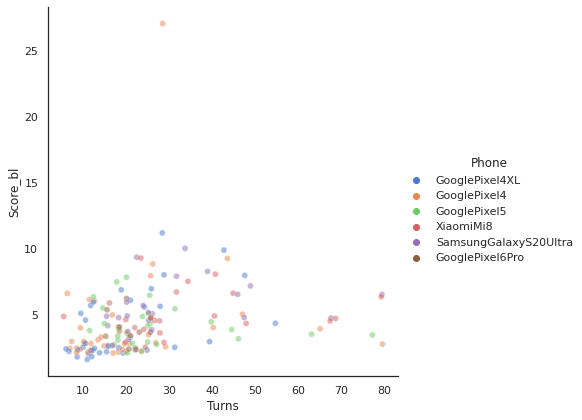

In [ ]:
## if sns is preferred over plotly
import seaborn as sns
sns.set_theme(style="white")


# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="Turns", y="Score_bl", hue="Phone",
            sizes=(400, 800), alpha=.5, palette="muted",
            height=6, data=dur_df)
plt.savefig('saving-a-seaborn-plot-as-pdf-file-300dpi.pdf', 
           dpi=300)

In [ ]:
## outlier

dur_df.loc[dur_df['Score_bl'] > 25]

TripID         Phone   Duration   Score_bl   Score_kf  Turns
33  2020-07-08-US-MTV-2  GooglePixel4  35.316667  27.078146  23.852413   28.5

In [ ]:
dur_df['Duration'] = dur_df['Duration'].astype(float)

In [ ]:
fig6 = go.Figure(data=[
    go.Scatter(x=dur_df.groupby('TripID').mean()['Duration'], y=dur_df.groupby('TripID').mean()['Score_bl'], mode='markers',\
marker_color=('#9DA4DB'), name = 'Baseline Score')])
fig6.update_layout( plot_bgcolor='white', title_text= 'The Effect of Trip Duration on GNSS Error', \
title_x=0.5, xaxis_title="Duration of the trip", yaxis_title="Baseline Score", legend=dict(x=1.0, y=0.5))
fig6.update_yaxes(showgrid=True, gridwidth=0.3, gridcolor='#ededed')
fig6.update_xaxes(showgrid=True, gridwidth=0.3, gridcolor='#ededed')


In [ ]:
## relationship between duration and error for each phone type (double click on phone name to isolate it)

fig6__ = go.Figure(data=[
    go.Scatter(x=dur_df.loc[dur_df['Phone'] == 'GooglePixel4']['Duration'], y=dur_df.loc[dur_df['Phone'] == 'GooglePixel4']['Score_bl'], mode='markers',\
marker_color=('#9DA4DB'), name = 'GooglePixel4'),
go.Scatter(x=dur_df.loc[dur_df['Phone'] == 'GooglePixel4XL']['Duration'], y=dur_df.loc[dur_df['Phone'] == 'GooglePixel4XL']['Score_bl'], mode='markers',\
marker_color=('#EE854A'), name = 'GooglePixel4XL'), 
go.Scatter(x=dur_df.loc[dur_df['Phone'] == 'GooglePixel5']['Duration'], y=dur_df.loc[dur_df['Phone'] == 'GooglePixel5']['Score_bl'], mode='markers',\
marker_color=('#BBD6B9'), name = 'GooglePixel5'),
go.Scatter(x=dur_df.loc[dur_df['Phone'] == 'GooglePixel6Pro']['Duration'], y=dur_df.loc[dur_df['Phone'] == 'GooglePixel6Pro']['Score_bl'], mode='markers',\
marker_color=('#A9C2DB'), name = 'GooglePixel6Pro'),
go.Scatter(x=dur_df.loc[dur_df['Phone'] == 'SamsungGalaxyS20Ultra']['Duration'], y=dur_df.loc[dur_df['Phone'] == 'SamsungGalaxyS20Ultra']['Score_bl'], mode='markers',\
marker_color=('#EFEF9E'), name = 'SamsungGalaxyS20Ultra'),
go.Scatter(x=dur_df.loc[dur_df['Phone'] == 'XiaomiMi8']['Duration'], y=dur_df.loc[dur_df['Phone'] == 'XiaomiMi8']['Score_bl'], mode='markers',\
marker_color=('#AAB5B5'), name = 'XiaomiMi8')])
fig6__.update_layout( plot_bgcolor='white', title_text= 'The Effect of Trip Duration on GNSS Error', \
title_x=0.5, xaxis_title="Duration of the trip", yaxis_title="Baseline Score", legend=dict(x=1.0, y=0.5))
fig6__.update_yaxes(showgrid=True, gridwidth=0.3, gridcolor='#ededed')
fig6__.update_xaxes(showgrid=True, gridwidth=0.3, gridcolor='#ededed')


In [ ]:
path = '/content/drive/MyDrive/Google_decimeter/smartphone-decimeter-2022/'

data = []

# Loop for each trip
for i, dirname in enumerate(tqdm(sorted(gl.glob(f'{path}/train/*/*/')))):
  # if cnt == 2:
  #   break
  drive, phone = dirname.split('/')[-3:-1]
  
  gt_data = pd.read_csv(f'{dirname}/ground_truth.csv')  # ground truth
  gt_data['TripID'] = drive
  gt_data['Phone'] = phone
  data.append(gt_data)
#   fig = px.scatter_mapbox(gt_data,lat="LatitudeDegrees", lon="LongitudeDegrees", color = drive,
#                         zoom=12, center={"lat":37.45, "lon":-122.27},
#                         height=600, width=800)
#   fig.update_layout(mapbox_style='stamen-terrain')
# fig.show()

  0%|          | 0/170 [00:00<?, ?it/s]

In [ ]:
appended_data = pd.concat(data)

In [ ]:
appended_data.columns

Index(['MessageType', 'Provider', 'LatitudeDegrees', 'LongitudeDegrees',
       'AltitudeMeters', 'SpeedMps', 'AccuracyMeters', 'BearingDegrees',
       'UnixTimeMillis', 'TripID', 'Phone'],
      dtype='object')

In [241]:
## Map for all ground truths of train data
fig = px.scatter_mapbox(appended_data,lat=appended_data['LatitudeDegrees'], lon=appended_data['LongitudeDegrees'], color = appended_data['TripID'],
                        zoom=8, center={"lat":37.45, "lon":-122.27},
                        height=600, width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()